In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using SPI
using NewickTree
using NewickTreeTools
using StatsPlots
using CSV, DataFrames
using StatsBase

In [2]:
NCUTS = 100
NPERMS = 5
NBOOT = 50

function clusters_per_cutlevel(distfun::Function, tree::Node, ncuts::Number)
    minmax = extrema(mapinternalnodes(distfun, tree, tree))
    cuts = range(0, minmax[2], length=ncuts)
    clusts = [cuttree(distfun, tree, cut) for cut in cuts]
    clustmappings = map(c->getleafnames.(c), clusts)
    clustersmps = [vcat(clustmapping...) for clustmapping in clustmappings]
    clusterids = [Int.(vcat([zeros(length(c)) .+ j for (j, c) in enumerate(clustmapping)]...)) for clustmapping in clustmappings];
    return clusterids, clustersmps
end

function pairedMIagainstmetacolumn(metacolumns, IDS, clusterids, clustersmps; bootstrap=false, mask=nothing)
    tstat_MI = zeros(length(clusterids), size(metacolumns, 2))
    for (i, mcol) in enumerate(eachcol(metacolumns))
        # cat = levelorder(categorical(mcol))
        # pcat = cat .== cat'
        pcat = mcol .== permutedims(replace(mcol, ""=>"missing"))
        tstat_MI[:, i] .= collectMI_across_treedepth(clusterids, clustersmps, IDS, pcat; bootstrap, mask)
    end
    DataFrame(tstat_MI, names(metacolumns)) |> stack |> df->rename!(df,["taxaID","MI"]);
end

function collectMI_across_treedepth(clusterids, clustersmps, IDS, ptax; bootstrap=false, mask=nothing)
    uppertriangle = triu(trues(size(ptax)), 1);
    uppertriangle = isnothing(mask) ? uppertriangle : uppertriangle[mask, mask]
    # ptax = if isnothing(mask) ptax[uppertriangle] else ptax[mask, mask][uppertriangle] end
    map(clusterids, clustersmps) do cids, smps; ptax, IDS, mask
        clustorder = indexin(IDS, smps)
        pcids = cids[clustorder] .== cids[clustorder]'
        pcids = if isnothing(mask) pcids else pcids[mask, mask] end
        wptax = if isnothing(mask) ptax else ptax[mask, mask] end
        pcids = pcids[uppertriangle]
        wptax = wptax[uppertriangle]
        if bootstrap
            vals_idx = sample(axes(pcids, 1), length(pcids), replace=true)
            pcids = pcids[vals_idx]
            wptax = wptax[vals_idx]
        end
        empiricalMI(wptax, pcids)
    end
end

collectMI_across_treedepth (generic function with 1 method)

In [3]:
pdir = plotsdir("UP7047_neighborjoined_spitree") |> mkpath

"/Users/ben/projects/Doran_etal_2022/plots/UP7047_neighborjoined_spitree"

In [4]:
tdir = projectdir("_research", "UP7047_neighborjoined_spitree")
ddir = datadir("exp_raw", "UP7047")

"/Users/ben/projects/Doran_etal_2022/data/exp_raw/UP7047"

In [5]:
spitree = readnw(open(readline, joinpath(tdir, "2020_02_UP7047-supporttree.nw")))


((((((((((UP000196862:0.3726263,UP000196784:0.2678048)0.48:0.01294178,((((((((UP000000495:0.7054831,UP000031552:0.4500539)0.24:0.08432527,UP000220251:0.3681296)0.71:0.07324412,UP000001505:0.515416)0.8366666666666667:0.05146068,(UP000000529:0.8304454,UP000069902:0.4625929)0.63:0.132667)0.874:0.0437504,UP000031320:0.5283071)0.975:0.06329066,UP000000496:1.215079)0.9428571428571428:0.1666593,UP000196763:0.3919022)0.8725:0.02545351,(UP000253816:0.1724787,UP000000431:0.3050015)0.44999999999999996:0.06158346)0.866:0.01776252)0.9575:0.07027833,UP000185544:0.591453)0.8838461538461538:0.01360717,(UP000218046:0.4953882,UP000053785:0.4936864)0.16000000000000003:0.03025781)0.766:0.004803309,(((((UP000035039:0.345209,UP000029283:1.035116)0.77:0.08784236,UP000035018:0.5590247)0.885:0.2052429,UP000053697:0.3172342)0.7433333333333334:0.03277148,UP000242542:0.4476391)0.6775:0.03476413,(UP000195277:0.593108,UP000242922:0.662811)0.56:0.04725994)0.4733333333333333:0.008022502)0.5272727272727273:0.00202137,

In [9]:
leafnames = getleafnames(spitree);

In [7]:
uprowmeta = CSV.read(joinpath(ddir, "UProwmeta.csv"), DataFrame);

In [11]:
# pairs of non-redundent species
(uprowmeta.Species .== permutedims(uprowmeta.Species))[triu(trues(7047, 7047), 1)] |> sum

147

In [22]:
taxonomylevels = ["Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"]
lineageroworder = indexin(leafnames, uprowmeta.proteomeID)
rowmeta = uprowmeta[lineageroworder, taxonomylevels]
rowmeta[!, "random"] .= sample(["0", "1"], nrow(rowmeta))
IDS = uprowmeta.proteomeID[lineageroworder]
for col in eachcol(rowmeta)
    replace!(col, missing=>"")
end

In [23]:
havelabels = vec(mapslices(r->all(r .!= ""), Matrix(rowmeta), dims=2));

In [26]:
spitree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, spitree)

@info "calculate tree cuts for SPI tree..."
@time clusterids_nj, clustersmps_nj = clusters_per_cutlevel(NewickTreeTools.network_distance, spitree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time spi_nj_MIdf = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids_nj, clustersmps_nj; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time spinj_bootstrappedMIs = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids_nj, clustersmps_nj; bootstrap=true, mask=havelabels)
    df.MI
end |> stack

@info "reformat boot replicates..."
@time begin
spi_nj_MIdf[!, :MI_boot_mean] = vec(mean(spinj_bootstrappedMIs, dims=2))
spi_nj_MIdf[!, :MI_boot_std] = vec(std(spinj_bootstrappedMIs, dims=2));
spiMI_nj__bootstraps_df = DataFrame(spinj_bootstrappedMIs, [Symbol("MI_boot_$i") for i in 1:size(spinj_bootstrappedMIs, 2)]);
SPInj_pltdf = hcat(spi_nj_MIdf, spiMI_nj__bootstraps_df);
boot_SPInj_pltdf = SPInj_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:10]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

┌ Info: calculate tree cuts for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/11_UniProt_SPItree_neighborjoining.ipynb:3


  4.632186 seconds (56.81 M allocations: 3.960 GiB, 13.27% gc time, 11.54% compilation time)


┌ Info: calculate test MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/11_UniProt_SPItree_neighborjoining.ipynb:6


405.273362 seconds (458.26 k allocations: 239.748 GiB, 3.43% gc time, 0.06% compilation time)


┌ Info: calculate boot MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/11_UniProt_SPItree_neighborjoining.ipynb:9


29467.485139 seconds (10.13 M allocations: 17.346 TiB, 3.96% gc time, 0.00% compilation time: 3% of which was recompilation)


┌ Info: reformat boot replicates...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/11_UniProt_SPItree_neighborjoining.ipynb:15


  6.017520 seconds (13.41 M allocations: 748.244 MiB, 2.94% gc time, 99.83% compilation time: 17% of which was recompilation)


Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,Kingdom,NaN,NaN
2,Kingdom,NaN,NaN
3,Kingdom,NaN,NaN
4,Kingdom,NaN,NaN
5,Kingdom,NaN,NaN
6,Kingdom,NaN,NaN
7,Kingdom,NaN,NaN
8,Kingdom,NaN,NaN
9,Kingdom,NaN,NaN


In [30]:
mdir = joinpath(tdir, "MIcurves") |> mkpath

"/Users/ben/projects/Doran_etal_2022/_research/UP7047_neighborjoined_spitree/MIcurves"

In [31]:
CSV.write(joinpath(mdir, "spi_nj_MI.csv"), spi_nj_MIdf)
CSV.write(joinpath(mdir, "spi_nj_MI_bootstraps.csv"), SPInj_pltdf)
CSV.write(joinpath(mdir, "spi_nj_MI_bootstraps_aggregated.csv"), boot_SPInj_pltdf)

"/Users/ben/projects/Doran_etal_2022/_research/UP7047_neighborjoined_spitree/MIcurves/spi_nj_MI_bootstraps_aggregated.csv"

In [ ]:
spi_nj_MIdf = CSV.read(joinpath(mdir, "spi_nj_MI.csv"), DataFrame)
SPInj_pltdf = CSV.read(joinpath(mdir, "spi_nj_MI_bootstraps.csv"), DataFrame)
boot_SPInj_pltdf = CSV.read(joinpath(mdir, "spi_nj_MI_bootstraps_aggregated.csv"), DataFrame)

In [33]:
NCUTS = 100

taxonomylevels = ["kingdom" "phylum" "class" "order" "family" "genus" "species"]
taxarankcolors = [:darkred :red :pink :orange :lightblue :green :aqua];
# taxonomylevels = ["kingdom" "phylum" "class" "order" "family" "genus"  "random"]
# taxarankcolors = [:darkred :red :pink :orange :lightblue :green  :grey];

1×7 Matrix{Symbol}:
 :darkred  :red  :pink  :orange  :lightblue  :green  :aqua

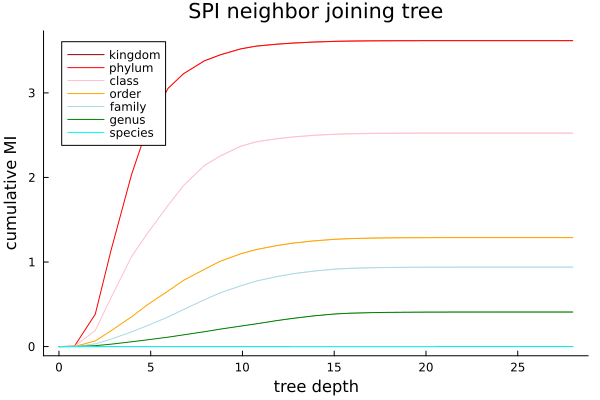

In [37]:
minmax = extrema(mapinternalnodes(network_distance, spitree_50pct, spitree_50pct))
cuts = range(0, minmax[2], length=NCUTS)
pltdf = filter(:taxaID=>!=("random"), spi_nj_MIdf)
plot(
    cuts,
    cumsum(reshape(pltdf.MI_boot_mean, 100, 7), dims=1),
    ribbon=cumsum(2 * reshape(pltdf.MI_boot_std, 100, 7), dims=1),
    title="SPI neighbor joining tree",
    ylabel="cumulative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    legend=:topleft,
)

In [38]:
savefig(joinpath(pdir, "CumulativeMI_SPI_NJ_tree.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UP7047_neighborjoined_spitree/CumulativeMI_SPI_NJ_tree.pdf"

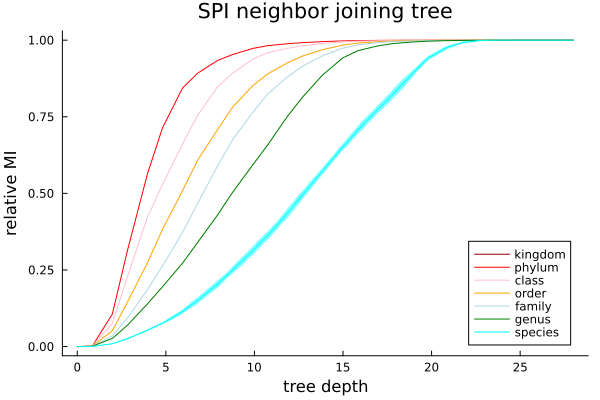

In [40]:
minmax = extrema(mapinternalnodes(network_distance, spitree_50pct, spitree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

pltdf = filter(:taxaID => !=("random"), boot_SPInj_pltdf)
plot(
    cuts,
    reshape(pltdf.cumulative_boot_mean, 100, 7),
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 7),
    title="SPI neighbor joining tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [41]:
savefig(joinpath(pdir, "RelativeMI_SPI_NJ_tree.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UP7047_neighborjoined_spitree/RelativeMI_SPI_NJ_tree.pdf"

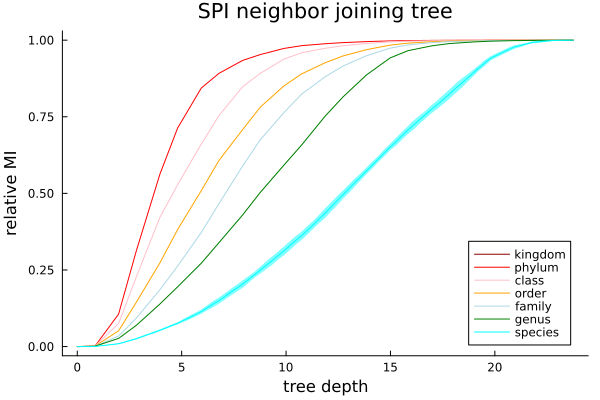

In [43]:
minmax = extrema(mapinternalnodes(network_distance, spitree_50pct, spitree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plottingrange = 1:85

pltdf = filter(:taxaID => !=("random"), boot_SPInj_pltdf)
plot(
    cuts[plottingrange],
    reshape(pltdf.cumulative_boot_mean, 100, 7)[plottingrange, :],
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 7)[plottingrange, :],
    title="SPI neighbor joining tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [44]:
savefig(joinpath(pdir, "RelativeMI_SPI_NJ_tree_zoomedintreedepth_treedepth1-85pct.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UP7047_neighborjoined_spitree/RelativeMI_SPI_NJ_tree_zoomedintreedepth_treedepth1-85pct.pdf"